In [1]:
import os
import glob
import itertools
import json
import importlib

import pingouin as pg
import matplotlib as mpl
import scipy.stats as spstats
import dill as pkl
import pandas as pd
import numpy as np
import seaborn as sns
import pylab as pl

import analyze2p.utils as hutils
import analyze2p.receptive_fields.utils as rfutils
import analyze2p.plotting as pplot
import analyze2p.extraction.rois as rutils
import analyze2p.aggregate_datasets as aggr
import analyze2p.objects.selectivity as sel

import analyze2p.decoding as dec

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.10, the latest is 0.4.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


# Aggregate

In [5]:
#### Plotting params
visual_areas, area_colors = pplot.set_threecolor_palette()
pplot.set_plot_params(labelsize=6, lw_axes=0.25)

In [6]:
sdata, cells0, missing_ = aggr.get_aggregate_info(visual_areas=visual_areas, 
                                                  create_new=False,
                                                  return_cells=True, return_missing=True)
all_cell_counts = cells0[['visual_area', 'datakey', 'cell']]\
                    .drop_duplicates().groupby(['visual_area']).count().reset_index()

print(all_cell_counts.groupby(['visual_area']).sum())

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 13 dsets
             datakey  cell
visual_area               
Li              3661  3661
Lm              4366  4366
V1              4028  4028


In [7]:
importlib.reload(aggr)

<module 'analyze2p.aggregate_datasets' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/aggregate_datasets.py'>

In [8]:
experiment='blobs'
trial_epoch = 'stimulus'
responsive_test='ROC'
# ---------------------------------------
responsive_thr=0.05 if responsive_test=='ROC' else 10.
response_type='dff'
traceid = 'traces001'

assigned_cells, meta = aggr.select_assigned_cells(cells0, sdata, 
                                        experiments=[experiment])
NDATA0 = aggr.load_responsive_neuraldata(experiment, traceid=traceid,
                                       response_type=response_type,
                                       trial_epoch=trial_epoch,
                                       responsive_test=responsive_test,
                                       responsive_thr=responsive_thr)

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 13 dsets
...loading: aggr_blobs_trialmeans_traces001_ROC-thr-0.05_dff_stimulus.pkl
Checking mislabeled


In [9]:
filter_rfs=False
if filter_rfs:
    cells_overlap = dec.get_cells_with_overlap(assigned_cells, sdata, 
                                 greater_than=False,
                                overlap_thr=0.)
    NDATA0_rf = aggr.get_neuraldata_for_included_cells(cells_overlap, NDATA0)
    curr_counts = NDATA0_rf[['visual_area', 'datakey', 'cell']].drop_duplicates()
else:
    curr_counts = NDATA0[['visual_area', 'datakey', 'cell']].drop_duplicates()

n_overlap = aggr.count_n_cells(curr_counts, name='cell')

In [10]:
# # Get unique dkeys and count
u_dkeys = aggr.drop_repeats(n_overlap)
min_ncells=10
if filter_rfs:
    NDATA_all = pd.concat([g for (va, dk), g in NDATA0_rf.groupby(['visual_area', 'datakey'])\
                   if (va, dk) in u_dkeys and len(g['cell'].unique())>=min_ncells])
else:
    NDATA_all = pd.concat([g for (va, dk), g in NDATA0.groupby(['visual_area', 'datakey'])\
                   if (va, dk) in u_dkeys and len(g['cell'].unique())>=min_ncells])

[V1] Animalid does not exist: JC078 


In [13]:
NDATA_im = None
i_=[]
for (va, dk), ndf in NDATA_all.groupby(['visual_area', 'datakey']):
    im_df = sel.exclude_lum_is_best(ndf, datakey=dk)
    i_.append(im_df)
NDATA_im = pd.concat(i_, axis=0, ignore_index=True)

# Output plotting

In [14]:
aggregate_dir= '/n/coxfs01/julianarhee/aggregate-visual-areas'
FIGDIR = os.path.join(aggregate_dir, 'FIGURES')
bw_area_colors={'V1': [0.7]*3, 'Lm': [0.7]*3, 'Li': [0.7]*3}
fontsize=6
lw=0.25

dst_dir = os.path.join(aggregate_dir, 'blobs-tuning', \
                       'selectivity_tolerance', 'final')
print(dst_dir)
if not os.path.exists(os.path.join(dst_dir,'examples')):
    os.makedirs(os.path.join(dst_dir, 'examples'))

data_id = '%s|%s_%s-%.2f' % (traceid, response_type, responsive_test, responsive_thr)
data_id

/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/selectivity_tolerance/final


'traces001|dff_ROC-0.05'

## Count fraction lum-preferring

In [15]:
cnts_all= aggr.count_n_cells(NDATA_all, name='n_cells').reset_index(drop=True)
cnts_im = aggr.count_n_cells(NDATA_im, name='n_cells').reset_index(drop=True)
cnts_all['stimuli'] = 'all'
cnts_im['stimuli'] ='images'
assert cnts_all.shape[0]==cnts_im.shape[0]
cnts = pd.concat([cnts_all, cnts_im], axis=0, ignore_index=True)

In [16]:
for va, g in cnts.groupby('visual_area'):
    dk_lut = dict((k, i) for i, k in enumerate(sorted(g['datakey'].unique())))
    cnts.loc[g.index, 'site_num'] = [dk_lut[k] for k in g['datakey'].values]

In [17]:
c_=[]
for (va, dk), g in cnts.groupby('visual_area'):
    all_c = g[g.stimuli=='all']['n_cells']
    im_c = g[g.stimuli=='images']['n_cells']
    curr_ = g[['visual_area', 'datakey', 'site_num']]\
                .drop_duplicates().copy().sort_values(by=['datakey', 'site_num'])
    curr_['n_all'] = all_c.values
    curr_['n_images'] = im_c.values
    curr_['pref_object'] = curr_['n_images']/curr_['n_all']
    curr_['n_luminance'] = curr_['n_all'] -  curr_['n_images']
    curr_['pref_object'] = curr_['n_images']/curr_['n_all']
    curr_['pref_luminance'] = curr_['n_luminance']/curr_['n_all']
    c_.append(curr_)
totals = pd.concat(c_, axis=0, ignore_index=True)

<IPython.core.display.Javascript object>


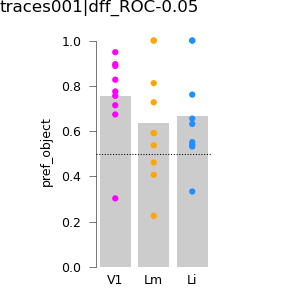

In [19]:
%matplotlib notebook
metric = 'pref_object'
fig, ax = pl.subplots(figsize=(2,2), dpi=150)
sns.stripplot(x='visual_area', y=metric, data=totals, ax=ax,
             hue='visual_area', palette=area_colors, size=3, jitter=False,
             order=visual_areas)
sns.barplot(x='visual_area', y=metric, data=totals, ax=ax,
             color=[0.8]*3, order=visual_areas, ecolor='w', ci=None)
ax.set_ylim([0,1.02])
ax.axhline(y=0.5, lw=0.5, ls=':', color='k')
ax.legend_.remove()
ax.set_box_aspect(2)
ax.tick_params(which='both', axis='x', size=0)
ax.set_xlabel('')

sns.despine(bottom=True, trim=True)
pplot.label_figure(fig, data_id)

figname = 'fraction_%s' % metric
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))

In [20]:
lum_cnts = cnts[cnts.stimuli=='all']['n_cells'].values - cnts[cnts.stimuli=='images']['n_cells'].values
sh_copy = cnts[cnts.stimuli=='all'].copy().reset_index(drop=True)
sh_copy['stimuli'] = 'luminance'
sh_copy['n_cells'] = lum_cnts
counts = pd.concat([cnts, sh_copy], axis=0, ignore_index=True)

<IPython.core.display.Javascript object>


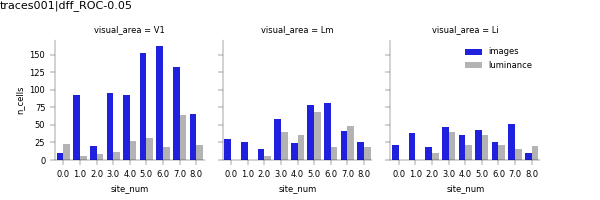

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/seaborn/axisgrid.py:648: UserWarning: Using the barplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


In [21]:
%matplotlib notebook
fg = sns.FacetGrid(col='visual_area', height=2, col_order=visual_areas,
            data=counts[counts.stimuli.isin(['luminance', 'images'])])
fg.map(sns.barplot, 'site_num', 'n_cells', 'stimuli', 
       palette={'luminance': [0.7]*3, 'images': 'blue'})
cnts.groupby('visual_area').min()
fg.fig.axes[-1].legend(frameon=False)
pl.subplots_adjust(bottom=0.2, right=0.9, top=0.8)

pplot.label_figure(fg.fig, data_id)

figname = 'n_lum_preferring_hists'
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))

# Calculate lifetime sparseness 

## Get all configs

In [22]:
SDF, mislabeled = aggr.check_sdfs(meta['datakey'].unique(), experiment=experiment,
                     images_only=False, rename=True, return_incorrect=True,
                     return_all=True)

### Example fov


#### Test some example cells

In [356]:
importlib.reload(sel)

<module 'analyze2p.objects.selectivity' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/objects/selectivity.py'>

In [371]:
# va='V1'
# dk = '20191006_JC110_fov1'

va='Li'
dk = '20190614_JC091_fov1'
# dk = '20191105_JC117_fov1' # rid 22
# dk ='20190422_JC076_fov1' # 293 

NDATA_tmp = NDATA_all.copy()
x0=NDATA_tmp[(NDATA_tmp.visual_area==va) & (NDATA_tmp.datakey==dk)].copy()
sdf = SDF[SDF.datakey==dk]
rdf0 = x0.groupby(['cell', 'config']).mean().reset_index().drop('trial', axis=1)

In [381]:
# rid = 304 # 20190614_JC091_fov1 Luminance response (strong)
# rid = 234 # weak lum response
rid = 331

# rid = 22 # 20191105_JC117_fov1 *lumonly
# rid = 293 # 20190422_JC076_fov1 *seems vv lum-modulated

<IPython.core.display.Javascript object>


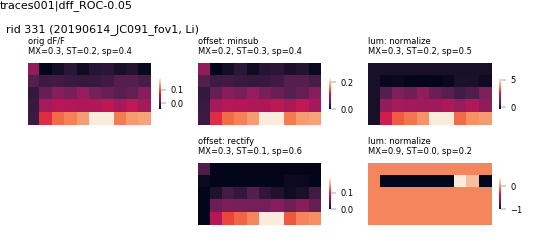

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/objects/selectivity.py:119: RuntimeWarning: invalid value encountered in double_scalars
  num = 1. - ((sum(responses/n)**2)/sum((responses**2)/n))
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packa

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/

/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/selectivity_tolerance/final examples test_offset_and_lum_EX__20190614_JC091_fov1_rid331


In [382]:
lcorrection='normalize'
fig, axn = pl.subplots(2, 3, figsize=(5.5,2.5))

rdf = rdf0.copy().reset_index(drop=True)
resp_og = sel.correct_offset(rdf, offset='none')
rdf_og = sel.correct_luminance(resp_og, sdf, lcorrection='none')
r_og = rdf_og[rdf_og['cell']==rid]

ixs_og = sel.calculate_metrics(rdf, sdf)
mp_, sz_, sp_ = ixs_og[ixs_og['cell']==rid][['morph_sel', 'size_tol', 'sparseness_morphs']].values[0]
og_str = 'orig dF/F\nMX=%.1f, ST=%.1f, sp=%.1f' \
                % (mp_, sz_, sp_)
    
ax= axn[0, 0]
ax.set_title(og_str, loc='left', fontsize=6) #'original dF/F')
tmat = np.reshape(r_og['response'].values, (10, 5)).T
sns.heatmap(tmat, ax=ax, cbar_kws={'shrink':0.5})
axn[1, 0].axis('off')

    
for ri, offset_type in enumerate(['minsub', 'rectify']):
    rdf = rdf0.copy().reset_index(drop=True)
    # correct offset
    resp_offset = sel.correct_offset(rdf, offset=offset_type)
    # without lum normalize
    rdf_offset = sel.correct_luminance(resp_offset, sdf, lcorrection='none')
    # lum normalize
    rdf_corrected = sel.correct_luminance(resp_offset, sdf, lcorrection=lcorrection)

    ixs_off = sel.calculate_metrics(rdf_offset, sdf)
    mp_o, sz_o, sp_o = ixs_off[ixs_off['cell']==rid][['morph_sel', 'size_tol', 'sparseness_morphs']].values[0]
    off_str = 'offset: %s\nMX=%.1f, ST=%.1f, sp=%.1f' \
                    % (offset_type, mp_o, sz_o, sp_o)
    
    ixs_corr = sel.calculate_metrics(rdf_corrected, sdf)
    mp_c, sz_c, sp_c = ixs_corr[ixs_corr['cell']==rid][['morph_sel', 'size_tol', 'sparseness_morphs']].values[0]
    corr_str = 'lum: %s\nMX=%.1f, ST=%.1f, sp=%.1f' \
                    % (lcorrection, mp_c, sz_c, sp_c)
    
    # Current roi values
    r_off = rdf_offset[rdf_offset['cell']==rid]
    r_lum = rdf_corrected[rdf_corrected['cell']==rid]

    ax=axn[ri, 1]
    ax.set_title(off_str, loc='left', fontsize=6) #'offset: %s' % offset_type)
    tmat = np.reshape(r_off['response'].values, (10, 5)).T
    sns.heatmap(tmat, ax=ax,cbar_kws={'shrink':0.5})

    ax=axn[ri,2]
    ax.set_title(corr_str, loc='left', fontsize=6) #'lum: %s' % lcorrection)
    tmat = np.reshape(r_lum['response'].values, (10, 5)).T
    sns.heatmap(tmat, ax=ax, cbar_kws={'shrink':0.5})

for ax in axn.flat:
    ax.set_aspect('equal')
    ax.axis('off')
pl.subplots_adjust(bottom=0.1, left=0.05, right=0.95, wspace=0.1, 
                   top=0.75, hspace=0.6)
fig.text(0.01, 0.87, 'rid %i (%s, %s)' % (rid, dk, va), fontsize=8)

pplot.label_figure(fig, data_id)

figname = 'test_offset_and_lum_EX__%s_rid%03d' % (dk, rid)

pl.savefig(os.path.join(dst_dir, 'examples', '%s.svg' % figname))
print(dst_dir, 'examples', figname)

In [380]:
ixs_corr[ixs_corr['cell']==rid]

,morph_sel,size_tol,sparseness_total,sparseness_morphs,sparseness_anchors,size_sel,lum_sel,lum_size_cc,lum_size_pval,cell
39,0.39778,0.0,0.846072,0.828581,0.904938,1.0,NaN,NaN,NaN,234


<IPython.core.display.Javascript object>


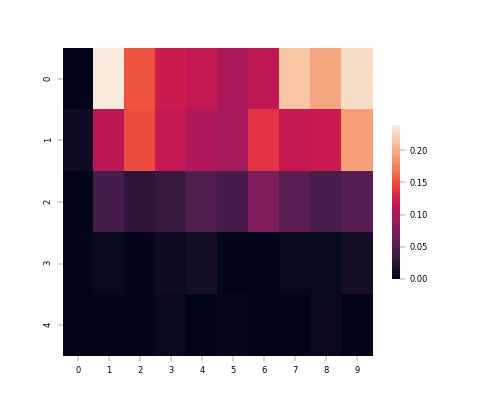

<AxesSubplot:>

In [376]:
g = resp_offset[resp_offset['cell']==rid].copy()
fig, ax = pl.subplots()
tmat = np.reshape(g['response'].values, (10, 5)).T
sns.heatmap(tmat, ax=ax,cbar_kws={'shrink':0.5})

In [377]:
sz = 50
s_df = sdf[sdf['size']==sz].copy()
curr_sz_cfgs = s_df.index.tolist()
lum = s_df[s_df['morphlevel']==-1].index.tolist()
lum_r = float(g[g.config.isin(lum)]['response'])
resp_at_size = g[g.config.isin(curr_sz_cfgs)].copy() 
new_vs = (resp_at_size['response']-lum_r)/lum_r


In [378]:
new_vs


1954    NaN
1959    NaN
1964    NaN
1969    inf
1974    NaN
1979    inf
1984    inf
1989    inf
1994    inf
1999    NaN
Name: response, dtype: float64

In [322]:
curr_ixs = sel.calculate_metrics(rdf_corrected, sdf)
mp, sz, sp = curr_ixs[curr_ixs['cell']==rid][['morph_sel', 'size_tol', 'sparseness_morphs']].values[0]
print(mp, sz, sp)

SyntaxError: unexpected EOF while parsing (<ipython-input-322-47227ad4323c>, line 3)

In [321]:
offset_types=['none', 'minsub', 'rectify', 'lumnorm', 'lumexcl']
i_list=[]
tmats={}
for offset in offset_types:
    curr_rdf = correct_offset(rdf0, offset=offset)
    tmats[offset] = curr_rdf
    curr_ixs = calculate_metrics(curr_rdf, sdf)
    curr_ixs['offset'] = offset
    i_list.append(curr_ixs)
ixs_ = pd.concat(i_list, axis=0)
ixs_['offset'].unique()

NameError: name 'correct_offset' is not defined

<IPython.core.display.Javascript object>


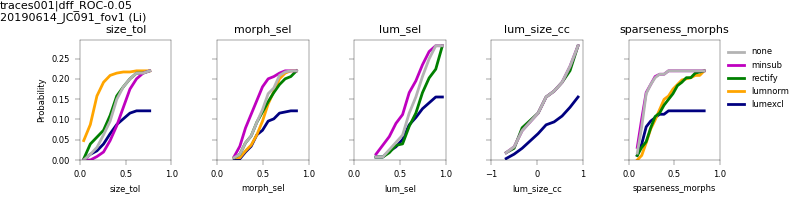

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/seaborn/_statistics.py:356: RuntimeWarning: invalid value encountered in true_divide
  hist = hist.astype(float) / hist.sum()
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/seaborn/_statistics.py:356: RuntimeWarning: invalid value encountered in true_divide
  hist = hist.astype(float) / hist.sum()


In [509]:
offset_colors={'none': [0.7]*3, 'minsub': 'm', 'rectify': 'green',
              'lumnorm': 'orange', 'lumexcl': 'navy'}

metric_list=['size_tol', 'morph_sel', 'lum_sel', 'lum_size_cc', 'sparseness_morphs']
fig, axn = pl.subplots(1, len(metric_list), figsize=(8,2), sharex=False, sharey=True)

for ai, (ax, metric) in enumerate(zip(axn, metric_list)):
    sns.histplot(x=metric, hue='offset', data=ixs_, 
                hue_order=offset_types,
                palette=offset_colors, ax=ax, stat='probability', element='poly',
                cumulative=True, fill=False, lw=2, common_norm=True)
    ax.set_title(metric)
    xlim = (-1, 1) if metric=='lum_size_cc' else (0, 1)
    ax.set_xlim(xlim)
    if ai!=(len(metric_list)-1):
        ax.legend_.remove()
        
leg = ax.get_legend()
leg_h = leg.legendHandles
leg.remove()
axn[-1].legend(handles=leg_h, labels=offset_types,
               bbox_to_anchor=(1,1), loc='upper left', frameon=False) 


pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8, 
                   wspace=0.5, hspace=0.8)

pplot.label_figure(fig, data_id)

fig.text(0.0, 0.9, '%s (%s)' % (dk, va), fontsize=8)

figname = 'metricdists_%s_%s' % (va, dk)
pl.savefig(os.path.join(dst_dir, 'examples', '%s.svg' % figname))

<IPython.core.display.Javascript object>


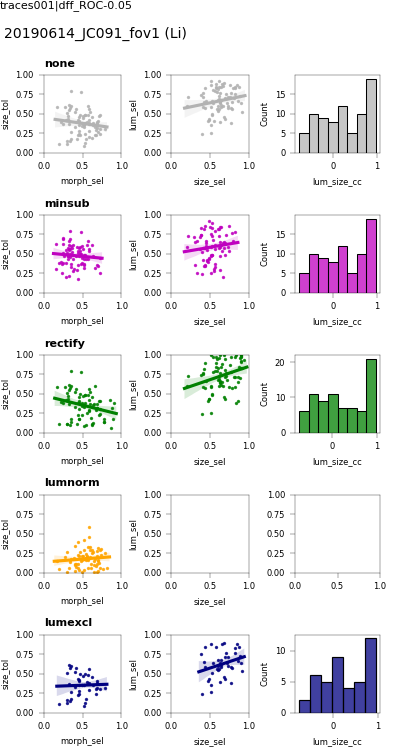

In [510]:
fig, axn = pl.subplots(len(offset_types), 3, figsize=(4,1.5*len(offset_types)))
for ri, (offset, curr_ixs) in enumerate(ixs_.groupby('offset')):
    ri = offset_types.index(offset)
    ax=axn[ri, 0]
    ax.set_title(offset, loc='left', fontsize=8, fontweight="bold")
    sns.regplot(x='morph_sel', y='size_tol', data=curr_ixs, ax=ax, 
                truncate=False, color=offset_colors[offset], scatter_kws={'s':2})
    ax.set_aspect('equal')
    ax.set_ylim([0, 1])
    ax.set_xlim([0, 1])
    
    ax=axn[ri, 1]
    sns.regplot(x='size_sel', y='lum_sel', data=curr_ixs, ax=ax,
                truncate=False, color=offset_colors[offset], scatter_kws={'s':2})
    ax.set_aspect('equal')
    ax.set_ylim([0, 1])
    ax.set_xlim([0, 1])
    
    ax=axn[ri, 2]
    sns.histplot(x='lum_size_cc', data=curr_ixs, ax=ax,
                color=offset_colors[offset])

pl.subplots_adjust(left=0.1, right=0.95, bottom=0.05, top=0.9, 
                   wspace=0.5, hspace=0.8)
pplot.label_figure(fig, data_id)

fig.text(0.01, 0.95, '%s (%s)' % (dk, va), fontsize=10)

figname = 'testoffsets_corrs_%s_%s' % (va, dk)
pl.savefig(os.path.join(dst_dir, 'examples', '%s.svg' % figname))


In [511]:
cfg_list = sorted(sdf.index.tolist())
cfgs = [sdf.loc[c]['morphlevel'] for c in cfg_list]
np.reshape(cfgs, (10, 5)).T #.astype(float)


array([[ -1,   0,  14,  27,  40,  53,  66,  79,  92, 106],
       [ -1,   0,  14,  27,  40,  53,  66,  79,  92, 106],
       [ -1,   0,  14,  27,  40,  53,  66,  79,  92, 106],
       [ -1,   0,  14,  27,  40,  53,  66,  79,  92, 106],
       [ -1,   0,  14,  27,  40,  53,  66,  79,  92, 106]])

<IPython.core.display.Javascript object>


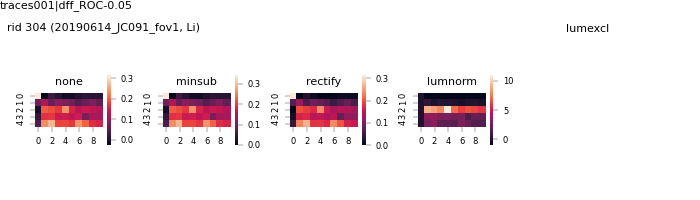

304 not found: lumexcl


In [512]:
rid = 304
fig, axn = pl.subplots(1, len(offset_types), figsize=(7,2))
for ai, offset in enumerate(offset_types):
    ax = axn[ai]
    ax.set_title(offset)
    tarray = tmats[offset].copy()
    if rid not in tarray['cell'].unique():
        print("%i not found: %s" % (rid, offset))
        ax.axis('off')
        continue
    tmat = np.reshape(tarray[tarray.cell==rid]['response'].values, (10, 5)).T
    sns.heatmap(tmat, ax=ax, cbar_kws={'shrink': 0.5})
    ax.set_aspect('equal')
pl.subplots_adjust(left=0.05, right=0.9, bottom=0.1, top=0.8, 
                  wspace=0.5)

fig.text(0.01, 0.85, 'rid %i (%s, %s)' % (rid, dk, va), fontsize=8)
pplot.label_figure(fig, data_id)

In [599]:
'20190602_JC091_fov1' in NDATA['datakey'].unique()

True

# Aggregate metrics

In [204]:
importlib.reload(sel)

<module 'analyze2p.objects.selectivity' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/objects/selectivity.py'>

In [438]:
exclude=[] # wrong configs
#exclude_by_fraction = False
#remove_offset=False # Set false, offsets removed if neg. in calculatin index
#normalize_luminance = False
offset_type = 'minsub'
lcorrection = 'exclude'
NDATA = NDATA_all.copy() #if normalize_luminance else NDATA_im.copy()
# ----------------------------------------------------------------
ixdf = sel.aggregate_cell_metrics(NDATA, offset_type=offset_type, 
                                 lcorrection=lcorrection)
print(ixdf['n_cells'].min())

    skippping, Li, 20190315_JC070_fov1 (no lum)
    skippping, Li, 20190322_JC073_fov1 (no lum)
    skippping, Lm, 20190306_JC061_fov3 (no lum)
    skippping, Lm, 20190322_JC073_fov1 (no lum)
22


In [439]:
exclude_by_fraction=False
min_pref_lum = 0.4 if exclude_by_fraction else 1.0
pref_obj = [(k, v) for k, v in \
            totals[totals['pref_luminance']<min_pref_lum][['visual_area', 'datakey']].values]

In [440]:
min_ncells=10
print(ixdf.shape)
lum_cols = [k for k in ixdf.columns if 'lum' in k]
if lcorrection=='normalize':
    for k in lum_cols:
        ixdf = ixdf.drop(k, 1)

xdf = ixdf[(ixdf['size_sel']<=1) & (ixdf['size_sel']>=0)
          & (ixdf['morph_sel']<=1) & (ixdf['morph_sel']>=0)
          & (ixdf['sparseness_morphs']<=1) & (ixdf['sparseness_morphs']>=0)].copy()
print(ixdf.shape, ixdf.dropna().shape, xdf.shape)

if exclude_by_fraction:
    DF = pd.concat([g for (va, dk), g in ixdf[ixdf['n_cells']>=min_ncells]\
                                              .groupby(['visual_area', 'datakey'])\
             if (va, dk) in pref_obj], axis=0, ignore_index=True)
else:
    DF = ixdf[ixdf['n_cells']>=min_ncells].copy().dropna()


(1402, 13)
(1402, 13) (1402, 13) (1402, 13)


In [441]:
print('size_tol', ixdf[(ixdf['size_tol']>1) | (ixdf['size_tol']<0)].shape)
print('morph_sel', ixdf[(ixdf['morph_sel']>1) | (ixdf['morph_sel']<0)].shape)
print('sparseness_morphs', ixdf[(ixdf['sparseness_morphs']>1) | (ixdf['sparseness_morphs']<0)].shape)


size_tol (0, 13)
morph_sel (0, 13)
sparseness_morphs (0, 13)


In [442]:
# Get means by FOV
means_by_fov = DF.groupby(['visual_area', 'datakey']).median().reset_index()
ncells_by_fov = DF.groupby(['visual_area', 'datakey']).count().reset_index()[['visual_area', 'datakey', 'cell']]\
                    .rename(columns={'cell': 'n_cells'})
fovdf = pd.merge(means_by_fov, ncells_by_fov, on=['visual_area', 'datakey'])

In [443]:
#fig, axn = pl.subplots(3, max_nfovs, figsize=(6,3))
for va, vg in DF.groupby('visual_area'):
    dk_lut = dict((v, i) for i, v in enumerate(vg['datakey'].unique()))
    DF.loc[vg.index, 'site_num'] = [dk_lut[k] for k in vg['datakey'].values]
    
for va, vg in ixdf.groupby('visual_area'):
    dk_lut = dict((v, i) for i, v in enumerate(vg['datakey'].unique()))
    ixdf.loc[vg.index, 'site_num'] = [dk_lut[k] for k in vg['datakey'].values]

In [444]:
#norm_str = 'normlum' if normalize_luminance else 'addmin'
#exclude_str = 'exclude%.2f' % min_pref_lum if exclude_by_fraction else 'excludeNone'

#filter_str = '%s-%s' % (norm_str, exclude_str)
filter_str = 'offset-%s_lum-%s' % (offset_type, lcorrection)

print(filter_str)

offset-minsub_lum-exclude


In [445]:
exclude_by_fraction

False

<IPython.core.display.Javascript object>


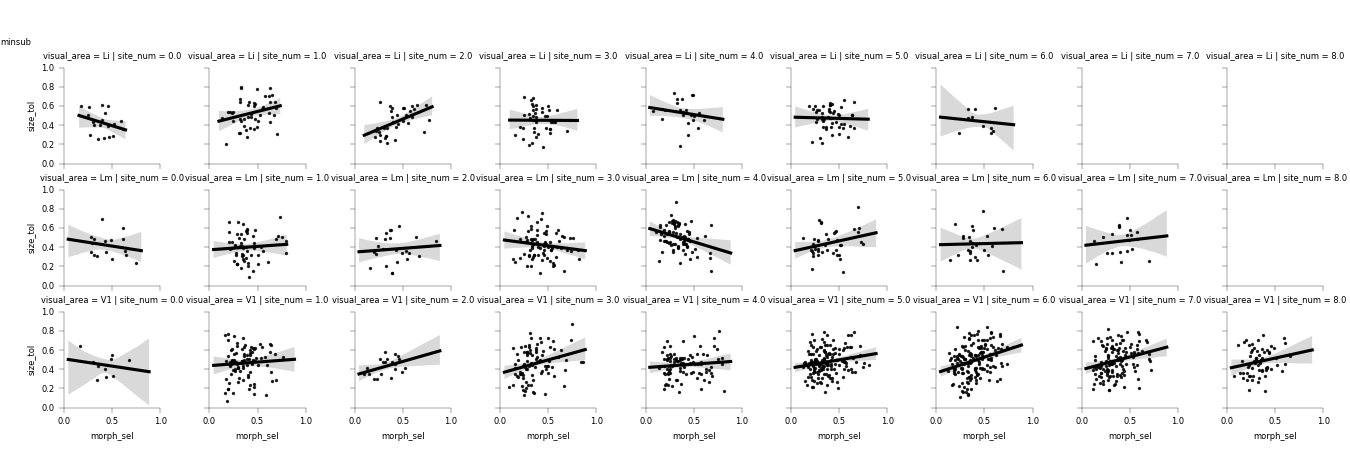

/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/selectivity_tolerance/final offset-minsub_lum-exclude_tradeoff_eachfov


In [446]:
fg = sns.FacetGrid(col='site_num', row='visual_area', data=DF, height=1.5)
fg.map(sns.regplot, 'morph_sel', 'size_tol',
            truncate=False, color='k', scatter_kws={'s':2})

for ax in fg.axes.flat:
    ax.set_aspect('equal')
    ax.set_ylim([0, 1])
    ax.set_xlim([0, 1])
pl.subplots_adjust(top=0.85)
    
fg.fig.text(0.0, 0.9, offset_type)
figname = '%s_tradeoff_eachfov' % (filter_str)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

<IPython.core.display.Javascript object>


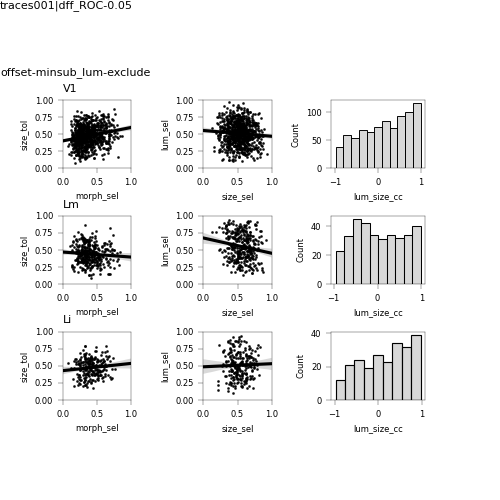

/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/selectivity_tolerance/final offset-minsub_lum-exclude_morphsel_v_sizetol_alldata


In [447]:
if lcorrection=='normalize':
    fig, axn = pl.subplots(1, 3, figsize=(5,2))
    for va, ixs_ in DF.dropna().groupby('visual_area'):
        vi = visual_areas.index(va)
        ax=axn[vi]
        ax.set_title(va, loc='left')
        sns.regplot(x='morph_sel', y='size_tol', data=ixs_, ax=ax, 
                    truncate=False, color='k', scatter_kws={'s':1})
        ax.set_aspect('equal')
        ax.set_ylim([0, 1])
        ax.set_xlim([0, 1])
else:
    fig, axn = pl.subplots(3,3, figsize=(5,5))
    for ax in axn[:, 0:-1].flat:
        ax.set_aspect('equal')
        ax.set_ylim([0, 1])
        ax.set_xlim([0, 1])
    for va, ixs_ in DF.dropna().groupby('visual_area'):
        vi = visual_areas.index(va)
        ax=axn[vi, 0]
        ax.set_title(va, loc='left')
        sns.regplot(x='morph_sel', y='size_tol', data=ixs_, ax=ax, 
                    truncate=False, color='k', scatter_kws={'s':1})
        ax=axn[vi, 1]
        sns.regplot(x='size_sel', y='lum_sel', data=ixs_, ax=ax,
                    truncate=False, color='k', scatter_kws={'s':1})
        ax=axn[vi, 2]
        sns.histplot(x='lum_size_cc', data=ixs_, ax=ax,
                    color=[0.8]*3)

pl.subplots_adjust(left=0.1, right=0.85, bottom=0.2, top=0.8, wspace=0.5,
                  hspace=0.7)

fig.text(0.0, 0.85, filter_str, fontsize=8)

pplot.label_figure(fig, data_id)

figname = '%s_morphsel_v_sizetol_alldata' % filter_str 
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

# pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))

[median]:
  visual_area  size_tol  morph_sel  sparseness_morphs   lum_sel  lum_size_cc  \
0          Li  0.482188   0.404903           0.170606  0.503155     0.220348   
1          Lm  0.438788   0.378419           0.189498  0.536886    -0.011819   
2          V1  0.471041   0.345127           0.194404  0.506980     0.206111   

   size_tol_std  morph_sel_std  sparseness_morphs_std  lum_sel_std  \
0      0.131161       0.134677               0.072419     0.193224   
1      0.140421       0.151215               0.098622     0.197823   
2      0.146436       0.151722               0.095854     0.171895   

   lum_size_cc_std  
0         0.556715  
1         0.549271  
2         0.558585  


<IPython.core.display.Javascript object>


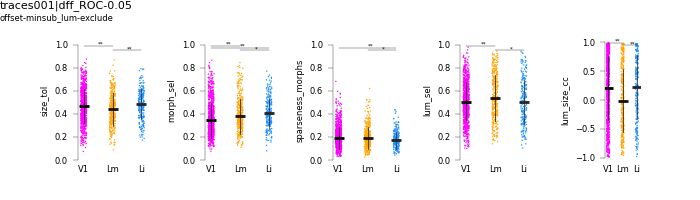

(0, 1.04)
(0, 1.04)
(0, 1.04)
(0, 1.04)
(-1.04, 1.04)
/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/selectivity_tolerance/final offset-minsub_lum-exclude_metrics_byCELL


In [448]:
%matplotlib notebook
mean_type = 'median'
multi_comp_test='fdr_bh' #'fdr_bh'

plot_params=['size_tol', 'morph_sel', 'sparseness_morphs']
fw=4
if lcorrection !='normalize':
    plot_params.extend(['lum_sel', 'lum_size_cc'])
    fw=7
markersize = 1 

plotdf = DF.dropna().copy()
# ----------------------------------------------------------
pplot.print_means(plotdf, groupby=['visual_area'], params=plot_params,
              metric=mean_type)
fig, axn = pl.subplots(1, len(plot_params), figsize=(fw, 2), sharex=True, sharey=False)
for ai, metric in enumerate(plot_params):
    ax=axn[ai]
    ylim=(-1.04,1.04) if metric=='lum_size_cc' else (0, 1.04)
    sel.stripplot_metric_by_area(plotdf, metric, area_colors=area_colors,
                                markersize=markersize, ylim=ylim, ax=ax,
                                sig_fontsize=4, jitter=True, 
                                plot_means=True, y_loc=0.95, offset=0.02,
                                mean_style='point', mean_type=mean_type)
pl.subplots_adjust(bottom=0.2, left=0.1, right=0.95, top=0.8, wspace=0.5)
fig.text(0.0, 0.9, filter_str)

pplot.label_figure(fig, data_id)
figname = '%s_metrics_byCELL' % (filter_str)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)


## By fov metrics

[mean]:
  visual_area  size_tol  morph_sel  sparseness_morphs   lum_sel  lum_size_cc  \
0          Li  0.469472   0.406830           0.177306  0.502153     0.193563   
1          Lm  0.424797   0.381933           0.199158  0.529842     0.074589   
2          V1  0.465869   0.348575           0.197297  0.495461     0.243860   

   size_tol_std  morph_sel_std  sparseness_morphs_std  lum_sel_std  \
0      0.049997       0.024580               0.024906     0.074066   
1      0.043158       0.034200               0.026747     0.100213   
2      0.019068       0.036036               0.022740     0.029894   

   lum_size_cc_std  
0         0.154719  
1         0.223631  
2         0.128364  


<IPython.core.display.Javascript object>


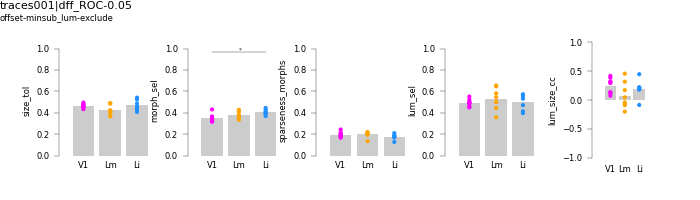

(0, 1.04)
(0, 1.04)
(0, 1.04)
(0, 1.04)
(-1.04, 1.04)
/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/selectivity_tolerance/final offset-minsub_lum-exclude_metrics_byFOV


In [449]:
%matplotlib notebook
mean_type='mean'
multi_comp_test='fdr_by' #'fdr_bh'

plot_params=['size_tol', 'morph_sel', 'sparseness_morphs']
fw=5
if lcorrection!='normalize':
    plot_params.extend(['lum_sel', 'lum_size_cc'])
    fw=7
markersize = 3

plotdf = fovdf.copy()
# ----------------------------------------------------------
pplot.print_means(plotdf, groupby=['visual_area'], params=plot_params,
                  metric=mean_type)
fig, axn = pl.subplots(1, len(plot_params), figsize=(fw, 2), sharex=True, sharey=False)
ylim=(0,1.04)
s_=[]
for ai, metric in enumerate(plot_params):
    ax=axn[ai]
    ylim = (-1.04,1.04) if metric=='lum_size_cc' else (0, 1.04)
    sel.stripplot_metric_by_area(plotdf, metric, area_colors=area_colors,
                                markersize=markersize, ylim=ylim, ax=ax,
                                sig_fontsize=4, jitter=False, 
                                plot_means=True, y_loc=0.95, offset=0.02,
                                mean_style='bar', mean_type=mean_type)
    sts['metric'] = metric
    s_.append(sts)
statsdf = pd.concat(s_, axis=0, ignore_index=True)

pl.subplots_adjust(bottom=0.2, left=0.1, right=0.95, top=0.8, wspace=0.6)

sns.despine(offset=8, trim=True, bottom=True)
fig.text(0.0, 0.9, filter_str)

pplot.label_figure(fig, data_id)
figname = '%s_metrics_byFOV' % (filter_str)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

In [450]:
r_=[]
for (va, dk), df_ in DF.groupby(['visual_area', 'datakey']):
    p_r, p_p = spstats.pearsonr(df_['morph_sel'], df_['size_tol'])
    res = pd.Series({'pearson_r': p_r, 'pearson_p': p_p,
               'visual_area': va, 'datkey': dk, 'n_cells': len(df_)})
    r_.append(res)
tradeoff = pd.concat(r_, axis=1, ignore_index=True).T
tradeoff['pearson_r'] = tradeoff['pearson_r'].astype(float)
tradeoff['pearson_p'] = tradeoff['pearson_p'].astype(float)

<IPython.core.display.Javascript object>


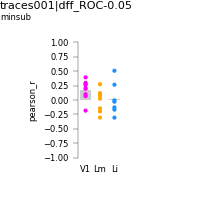

(-1.04, 1.04)
      Contrast   A   B  Paired  Parametric  U-val       Tail     p-unc  \
0  visual_area  Li  Lm   False       False   39.0  two-sided  0.224313   
1  visual_area  Li  V1   False       False   29.0  two-sided  0.832339   
2  visual_area  Lm  V1   False       False   19.0  two-sided  0.112351   

     p-corr p-adjust  eta-square       metric  
0  0.616861   fdr_by    0.085237  lum_size_cc  
1  1.000000   fdr_by    0.031144  lum_size_cc  
2  0.616861   fdr_by    0.182317  lum_size_cc  
/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/selectivity_tolerance/final offset-minsub_lum-exclude_tradeoff-pearsonr


In [451]:
metric = 'pearson_r'
fig, ax = pl.subplots(figsize=(2, 2))
sel.stripplot_metric_by_area(tradeoff, metric, area_colors=area_colors,
                                markersize=3, ylim=(-1.04, 1.04), ax=ax,
                                sig_fontsize=4, jitter=False, 
                                plot_means=True, y_loc=0.95, offset=0.02,
                                mean_type='mean', mean_style='bar')
# sts = pg.pairwise_ttests(data=tradeoff, dv=metric, between='visual_area',
#                     parametric=False, padjust=multi_comp_test, effsize='eta-square')
# pplot.annotate_multicomp_by_area(ax, sts, y_loc=0.9, offset=0.01,
#                     fontsize=4, lw=0.25)
print(sts)

pplot.label_figure(fig, data_id)
fig.text(0, 0.9, offset_type)
figname = '%s_tradeoff-pearsonr' % filter_str
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)


## Population sparseness

In [452]:
importlib.reload(sel)

<module 'analyze2p.objects.selectivity' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/objects/selectivity.py'>

In [453]:
#x0 = NDATA[(NDATA.visual_area==va) & (NDATA.datakey==dk)].copy()
remove_offset=False # Set false, offsets removed if neg. in calculatin index
NDATA = NDATA_all.copy() #if normalize_luminance else NDATA_im.copy()
pop_sparse = sel.aggregate_population_sparseness(NDATA, offset_type=offset_type)
popdf = pop_sparse[(pop_sparse['pop-sparseness']<=1.0) 
                 & (pop_sparse['pop-sparseness']>=0)].copy()
print(pop_sparse.shape, popdf.shape)

(1200, 5) (1200, 5)


In [454]:
if exclude_by_fraction:
    pDF = pd.concat([g for (va, dk), g in popdf[popdf['n_cells']>=min_ncells]\
                                              .groupby(['visual_area', 'datakey'])\
             if (va, dk) in pref_obj], axis=0, ignore_index=True)
else:
    pDF = popdf[popdf['n_cells']>=min_ncells].copy().dropna()
print(pDF.shape)
pop_by_fov = pDF.groupby(['visual_area', 'datakey']).mean().reset_index()
pop_by_config = pDF.groupby(['visual_area', 'config']).mean().reset_index()

(1200, 5)


<IPython.core.display.Javascript object>


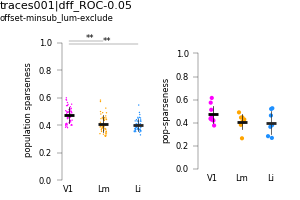

[mean]:
  visual_area  pop-sparseness  pop-sparseness_std
0          Li        0.400182            0.041929
1          Lm        0.409124            0.061699
2          V1        0.471140            0.059133
(0, 1.02)
[mean]:
  visual_area  pop-sparseness  pop-sparseness_std
0          Li        0.400182            0.105336
1          Lm        0.409124            0.066566
2          V1        0.471140            0.079024
(0, 1.02)
/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/selectivity_tolerance/final offset-minsub_lum-exclude_population_sparseness


In [455]:
%matplotlib notebook
metric = 'pop-sparseness'
multi_comp_test='fdr_bh' #'fdr_bh'

stat_cols = ['A', 'B', 'p-unc', 'p-corr', 'p-adjust', 'eta-square']
ylim = (0, 1.02)
y_loc = ylim[-1]-0.05

fig, axn = pl.subplots(1,2, figsize=(3,2))
for ai, ax in enumerate(axn.flat):
    plotdf = pop_by_config.dropna().copy() if ai==0 else pop_by_fov.copy()
    markersize = 1 if ai==0 else 3
    pplot.print_means(plotdf, groupby=['visual_area'], params=[metric], metric='mean')
    sel.stripplot_metric_by_area(plotdf, metric=metric, ax=ax, mean_type='mean',
                            area_colors=area_colors, markersize=markersize,
                            y_loc=y_loc, sig_lw=0.2, offset=0.02, ylim=ylim)
fig.text(0.0, 0.9, filter_str)
pl.subplots_adjust(bottom=0.1, left=0.2, right=0.95, top=0.8, wspace=0.6)

pplot.label_figure(fig, data_id)
#fig.axes[0].set_ylim(ylim)
fig.axes[0].set_ylabel('population sparseness')
figname = '%s_population_sparseness' % (filter_str)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

In [59]:
# Plot EACH condition separately by area:
# --------------------------------------------
# sdf_m = aggr.get_master_sdf(experiment='blobs', images_only=False)

# popdf['size'] = sdf_m.loc[popdf['config'].values, 'size'].values
# popdf['morphlevel'] = sdf_m.loc[popdf['config'].values, 'morphlevel'].values

# #fig, ax = pl.subplots(1, 1, figsize=(9,4)) #, tight_layout=True)
# fg = sns.FacetGrid(col='morphlevel', row='size', data=popdf, height=1)
# fg.map(sns.pointplot, 'visual_area', 'pop-sparseness', 'visual_area', 
#       order=visual_areas, join=False, markers='_', color='k',
#        ci=None, errwidth=0.5, scale=0.75)
# fg.map(sns.stripplot, 'visual_area', 'pop-sparseness', 'visual_area', 
#       order=visual_areas, palette=area_colors, hue_order=visual_areas, jitter=False,
#       dodge=0.5, size=2)
# pl.subplots_adjust(left=0.05, right=0.8, bottom=0.2, top=0.8)

In [212]:
morphlevels = sorted(sdf['morphlevel'].unique())
sizes = sorted(sdf['size'].unique())
n_morphs = len(morphlevels)
n_sizes = len(sizes)

va='V1'
dk='20191006_JC110_fov1'
df_= plotdf[(plotdf.visual_area==va) & (plotdf.datakey==dk)].copy()
cfg_list = sorted(df_.groupby('config')['pop-sparseness'].mean().index.tolist())
morph_arr = sdf.loc[cfg_list]['morphlevel'].values
morph_mat = np.reshape(morph_arr, (n_morphs, n_sizes)).T.astype(float)

size_arr = sdf.loc[cfg_list]['size'].values
size_mat = np.reshape(size_arr, (n_morphs, n_sizes)).T.astype(float)


In [213]:
mat_labels = np.asarray(['(%i, %i)' % (sz, mp) for sz, mp \
                         in sdf[['size', 'morphlevel']].values])\
                        .reshape(n_morphs, n_sizes).T

0.028456460327536622 0.8874716770509359


<IPython.core.display.Javascript object>


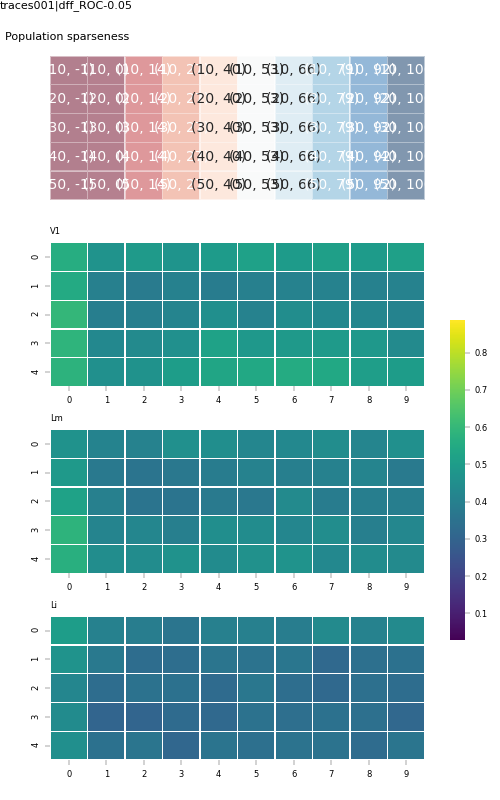

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


Text(0.01, 0.95, 'Population sparseness')

In [214]:
vmin=plotdf['pop-sparseness'].min()
vmax=plotdf['pop-sparseness'].max()
print(vmin, vmax)
cmap='viridis'
lw=0.1

fig, axn = pl.subplots(4, 1, constrained_layout=True, figsize=(5,8))
ax0 = axn[0]
sns.heatmap(morph_mat, annot=mat_labels, fmt='', ax=ax0, cbar=0, cmap='RdBu',
           alpha=0.5, linewidths=lw)
ax0.axis('off')
cbar_ax = fig.add_axes([.9, .2, .03, .4])
for va, df_ in plotdf.groupby('visual_area'):
    ai = visual_areas.index(va)
    ax = axn[ai+1] #fig.add_subplot(gs1[1+ai, 0:])
    vals = df_.groupby('config')['pop-sparseness'].mean().values
    resp_mat = np.reshape(vals, (n_morphs, n_sizes)).T.astype(float)
    sns.heatmap(resp_mat, fmt='', ax=ax, vmin=vmin, vmax=vmax, cmap=cmap,
               cbar=ai==0, cbar_ax=None if ai else cbar_ax, linewidths=lw)
    ax.set_title(va, loc='left', fontsize=6)
pl.subplots_adjust(left=0.1, top=.93, right=0.85, bottom=0.05, hspace=0.3)

pplot.label_figure(fig, data_id)
fig.text(0.01, 0.95, 'Population sparseness', fontsize=8)

In [78]:
DF['experiment'] = 'blobs'
DF = aggr.add_roi_positions(DF)

In [80]:
va = 'V1'
dk = '20191006_JC110_fov1'
df_ = DF[(DF.visual_area==va) & (DF.datakey==dk)]
df_.head()

,morph_sel,size_tol,sparseness_total,sparseness_morphs,sparseness_anchors,size_sel,lum_sel,lum_size_cc,lum_size_pval,cell,...,experiment,animalid,fov,session,fov_xpos,fov_xpos_pix,fov_ypos,fov_ypos_pix,ml_pos,ap_pos
2127,0.604329,0.710847,0.175357,0.151391,0.225023,0.289153,0.774502,-0.051729,0.934167,4,...,blobs,JC110,FOV1_zoom2p0x,20191006,251.190607,109.0,51.400391,27.0,921.399609,926.409393
2128,0.113957,0.647360,0.129247,0.110111,0.063657,0.352640,0.224575,0.088116,0.887952,5,...,blobs,JC110,FOV1_zoom2p0x,20191006,235.059100,102.0,89.474755,47.0,883.325245,942.540900
2129,0.638263,0.246049,0.244961,0.215403,0.310578,0.753951,0.443386,0.533107,0.354911,6,...,blobs,JC110,FOV1_zoom2p0x,20191006,244.277104,106.0,62.822701,33.0,909.977299,933.322896
2130,0.276746,0.485549,0.237714,0.209670,0.218234,0.514451,0.772925,0.617586,0.266994,11,...,blobs,JC110,FOV1_zoom2p0x,20191006,232.754599,101.0,72.341292,38.0,900.458708,944.845401
2131,0.729247,0.414062,0.183084,0.179927,0.384609,0.585938,0.346337,-0.126777,0.839016,12,...,blobs,JC110,FOV1_zoom2p0x,20191006,331.848141,144.0,24.748337,13.0,948.051663,845.751859


In [81]:
import analyze2p.correlations as cr

In [82]:
def do_pairwise_diffs_melt(df_, metric_name='morph_sel', include_diagonal=False):
    pairwise_diffs = pd.DataFrame(abs(df_[metric_name].values \
                                  - df_[metric_name].values[:, None]), 
                              columns=df_['cell'].values, index=df_['cell'].values)

    diffs = cr.melt_square_matrix(pairwise_diffs, metric_name=metric_name)
    diffs = diffs.rename(columns={'row': 'cell_1', 'col': 'cell_2'})
    diffs[['cell_1', 'cell_2']] = diffs[['cell_1', 'cell_2']].astype(int)
    diffs['neuron_pair'] = ['%i_%i' % (c1, c2) for \
                         c1, c2 in diffs[['cell_1', 'cell_2']].values]
    return diffs


In [83]:
d_=[]
for (va, dk), df_ in DF.groupby(['visual_area', 'datakey']):
    roi_pos = df_[['cell', 'ml_pos', 'ap_pos']].drop_duplicates().copy()
    d1 = do_pairwise_diffs_melt(df_, metric_name='morph_sel')
    d2 = do_pairwise_diffs_melt(df_, metric_name='lum_sel')
    d3 = do_pairwise_diffs_melt(df_, metric_name='size_tol')
    d4 = do_pairwise_diffs_melt(df_, metric_name='sparseness_morphs')
    
    diff_ = pd.merge(d1, d2).merge(d3).merge(d4)
    ddf_ = cr.get_pw_cortical_distance(diff_, roi_pos)
    ddf_['visual_area'] = va
    ddf_['datakey'] = dk
    d_.append(ddf_)
diffdf = pd.concat(d_, axis=0, ignore_index=True)

In [84]:
fov_means = diffdf.groupby(['visual_area', 'datakey']).mean().reset_index()
fov_means.head()

,visual_area,datakey,cell_1,cell_2,morph_sel,lum_sel,size_tol,sparseness_morphs,cortical_distance
0,Li,20190422_JC076_fov1,202.453202,287.891626,0.170288,0.250512,0.133455,0.096576,303.339730
1,Li,20190602_JC091_fov1,88.589682,216.628709,0.156862,0.202362,0.217484,0.071340,256.484549
2,Li,20190609_JC099_fov1,156.889098,233.496867,0.183989,0.192661,0.175153,0.069006,322.294311
3,Li,20190614_JC091_fov1,119.542791,278.405927,0.169190,0.183071,0.167691,0.077091,306.815104
4,Li,20191018_JC113_fov1,88.464385,128.003700,0.160087,0.217257,0.164234,0.081781,240.116138


<IPython.core.display.Javascript object>


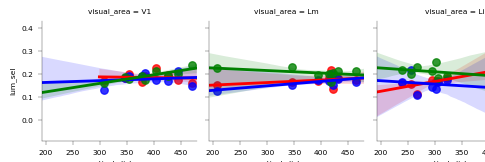

In [85]:
fg = sns.FacetGrid(col='visual_area', col_order=visual_areas, data=fov_means, 
                  height=2)
fg.map(sns.regplot, 'cortical_distance', 'morph_sel', truncate=False,
      color='r')
fg.map(sns.regplot, 'cortical_distance', 'size_tol', truncate=False,
      color='b')
fg.map(sns.regplot, 'cortical_distance', 'lum_sel', truncate=False,
      color='g')

In [86]:
# Binning params
n_bins=6
use_quartile=False
custom_bins=False
cmap='viridis'
qcolor_list = sns.color_palette(cmap, n_colors=n_bins)
# Bin data
to_quartile='cortical_distance'
bins, bin_labels, bin_colors = cr.get_bins(n_bins=n_bins, custom_bins=custom_bins)
bcorrs, bins_ = cr.bin_column_values(diffdf, to_quartile=to_quartile, 
                                     use_quartile=use_quartile, return_bins=True,
                                     n_bins=n_bins, bins=bins, labels=bin_labels)

In [87]:
# metric = 'morph_sel'
# print(bcorrs.groupby(['binned_%s' % to_quartile])[[to_quartile, metric]]\
#       .mean().to_markdown())

<IPython.core.display.Javascript object>


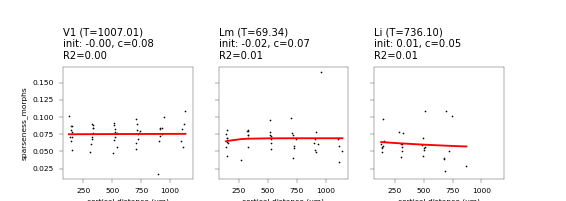

In [88]:
metric = 'sparseness_morphs'
fit_sites=True
min_npairs = 3
n_iter=0
x_var = 'binned_%s' % to_quartile
cnt_grouper = [x_var, 'datakey'] if fit_sites else [x_var]

fig, axn = pl.subplots(1,3, figsize=(7,2.5), sharex=True, sharey=True)
for va, cc0 in bcorrs.groupby('visual_area'):
    ax=axn[visual_areas.index(va)]
    pair_cnts = cc0.groupby(cnt_grouper)['neuron_pair'].count()  
    # How many resample per group
    nsamples_per = dict((k, v) for k, v \
                        in zip(pair_cnts[pair_cnts>min_npairs].index.tolist(),
                               pair_cnts[pair_cnts>min_npairs].values))
    # Sample
    cc_ = pd.concat([cg.sample(nsamples_per[c], random_state=n_iter, replace=True) \
                         for c, cg in cc0.groupby(cnt_grouper) \
                         if c in nsamples_per.keys()])
    # fov mean for visualizing
    fov_cc = cc_.groupby(cnt_grouper).median().reset_index().dropna()
    data = fov_cc.groupby(x_var).median()
    xd = data.sort_values(by=to_quartile)['cortical_distance'].values
    yd = data.sort_values(by=to_quartile)[metric].values
    #ax.plot(xd, yd, lw=0, color='k', marker='.')
    sns.scatterplot(x=to_quartile, y=metric, data=fov_cc, ax=ax,
                    s=2, color='k')
    res_, xvals, yvals = cr.fit_decay_on_binned(fov_cc, use_binned=False,
                                                normalize_x=True, func='halflife',
                                                estimator='median',
                                                metric=metric, #bin_column=bin_column,
                                                to_quartile=to_quartile,
                                                return_inputs=True)
    if all(res_.isnull()):
        print("BINNED, no fit: %s" % va)
        label='no fit'
    else:
        fit_y = cr.func_halflife(xvals, res_.init, res_.tau, res_.constant)
        ax.plot(xvals, fit_y, color='r')
        label = '%s (T=%.2f)\ninit: %.2f, c=%.2f\nR2=%.2f' \
                                % (va, res_.tau, res_.init, res_.constant, res_.R2)
    ax.set_title(label, loc='left')
    ax.set_xlabel('cortical distance (um)')
pl.subplots_adjust(bottom=0.2, left=0.1, right=0.8, top=0.7)

In [112]:
va, dk

('V1', '20191006_JC110_fov1')

<IPython.core.display.Javascript object>


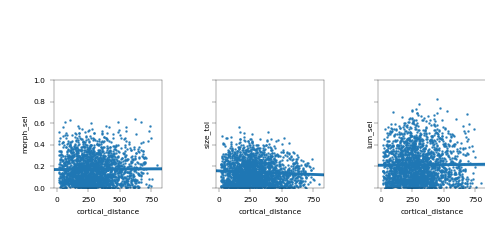

In [97]:
va='Li'
dk='20191105_JC117_fov1'
df_ = diffdf[(diffdf.visual_area==va) & (diffdf.datakey==dk)]

fig, axn = pl.subplots(1,3, figsize=(6, 3), sharex=True, sharey=True)
for ax, metric in zip(axn.flat, ['morph_sel', 'size_tol', 'lum_sel']):
    ax.set_ylim([0, 1])
    #ax.set_aspect('equal')
    sns.regplot(x='cortical_distance', y=metric, data=df_, ax=ax,
               truncate=False, scatter_kws={'s':1})
    ax.set_box_aspect(1)
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8, wspace=0.5)

<IPython.core.display.Javascript object>


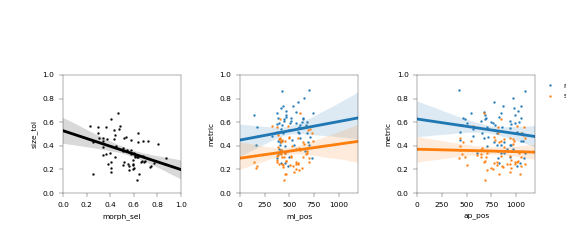

In [98]:
df_ = DF[(DF.visual_area==va) & (DF.datakey==dk)]
fig, axn = pl.subplots(1, 3, figsize=(7, 3), sharex=False, sharey=False)
ax=axn[0]
ax.set_ylim([0, 1])
ax.set_xlim([0, 1])
ax.set_aspect('equal')
sns.regplot(x='morph_sel', y='size_tol', ax=ax, data=df_,
           truncate=False, color='k', scatter_kws={'s':1})

for ax, axis in zip(axn.flat[1:], ['ml_pos', 'ap_pos']):
    ax.set_ylim([0,1])
    ax.set_xlim([0, 1200])
    sns.regplot(x=axis, y='morph_sel', ax=ax, data=df_, label='morph_sel',
               truncate=False, scatter_kws={'s':1})
    sns.regplot(x=axis, y='size_tol', ax=ax, data=df_, label='size_tol',
               truncate=False, scatter_kws={'s':1})
    ax.set_ylabel('metric')
    #ax.set_aspect(0.1)
    #force_aspect(ax,aspect=1)
    ax.set_box_aspect(1)
ax.legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False)

pl.subplots_adjust(left=0.1, right=0.85, bottom=0.2, top=0.8, wspace=0.5)

In [156]:
def get_best_x(rd):
    '''
    Get best morph and best size (rd=ndf[ndf.cell==x])
    '''
    sizr = sel.get_x_curves_at_best_y(rd[rd.morphlevel!=-1], 
                              x='size', y='morphlevel', normalize=False)
    best_mp = int(sizr['morphlevel'].unique())

    morphr = sel.get_x_curves_at_best_y(rd[rd.morphlevel!=-1], 
                              x='morphlevel', y='size', normalize=False)
    best_sz = int(morphr['size'].unique())

    return pd.Series({'morphlevel': best_mp, 'size': best_sz})



<IPython.core.display.Javascript object>


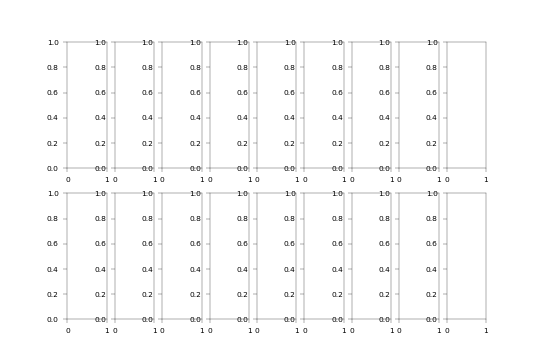

In [179]:
for (va, dk), df_ in DF.groupby(['visual_area', 'datakey']):
    ndf = pd.concat([NDATA[(NDATA.visual_area==va) & (NDATA.datakey==dk) 
              & (NDATA.cell.isin(g['cell'].unique()))] \
                for (va, dk), g in df_.groupby(['visual_area', 'datakey'])]).copy()
    ndf['size'] = sdf.loc[ndf['config'].values]['size'].values
    ndf['morphlevel'] = sdf.loc[ndf['config'].values]['morphlevel'].values
    bestvs = ndf.groupby('cell').apply(get_best_x)
    df_['best_morphlevel'] = bestvs.loc[df_['cell'].values]['morphlevel'].values
    df_['best_size'] = bestvs.loc[df_['cell'].values]['size'].values
    DF.loc[df_.index, 'best_morphlevel'] = df_['best_morphlevel']
    DF.loc[df_.index, 'best_size'] = df_['best_size']

<IPython.core.display.Javascript object>


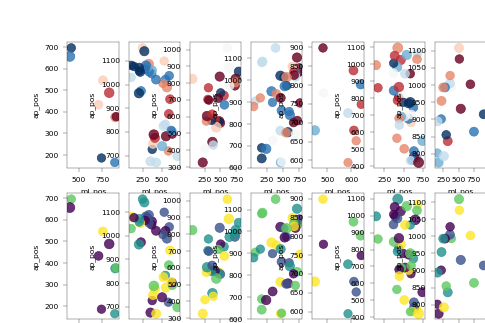

In [181]:
plotd = DF[(DF.visual_area=='Li') & (DF['morph_sel']>=0.5)].copy()

n_fovs = len(plotd['datakey'].unique())
fig, axn = pl.subplots(2, n_fovs, figsize=(6, 4), sharex=False, sharey=False)

for di, (dk, df_) in enumerate(plotd.groupby(['datakey'])):

    for hi, hue_name in enumerate(['best_morphlevel', 'best_size']):
        ax = axn[hi, di]
        metric_cmap = 'RdBu' if hue_name=='best_morphlevel' else 'viridis'
        hue_norm = (0, 106) if hue_name=='best_morphlevel' else (10, 50) 
        sns.scatterplot(x='ml_pos', y='ap_pos', data=df_, ax=ax, 
                    size=size_value, size_norm=(0, 1), palette=metric_cmap,
                    hue=hue_name, hue_norm=hue_norm,
                    edgecolor=None, alpha=0.8, legend=False)

In [185]:
importlib.reload(cr)

<module 'analyze2p.correlations' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/correlations.py'>

In [186]:
d_=[]
for (va, dk), df_ in DF.groupby(['visual_area', 'datakey']):
    roi_pos = df_[['cell', 'ml_pos', 'ap_pos']].drop_duplicates().copy()
    d1 = do_pairwise_diffs_melt(df_, metric_name='best_morphlevel')
    d2 = do_pairwise_diffs_melt(df_, metric_name='best_size')
    diff_ = pd.merge(d1, d2)
    ddf_ = cr.get_pw_distance(diff_, roi_pos)
    ddf_['visual_area'] = va
    ddf_['datakey'] = dk
    d_.append(ddf_)
diffdf = pd.concat(d_, axis=0, ignore_index=True)

<IPython.core.display.Javascript object>


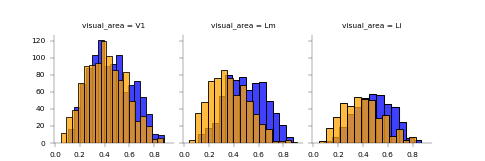

In [235]:
fg = sns.FacetGrid(col='visual_area', col_order=visual_areas, data=DF,
                  height=2)
fg.map(sns.histplot, 'morph_sel', color='blue')
fg.map(sns.histplot, 'size_tol', color='orange')

pl.subplots_adjust(left=0.1, bottom=0.2, top=0.8, right=0.8)

<IPython.core.display.Javascript object>


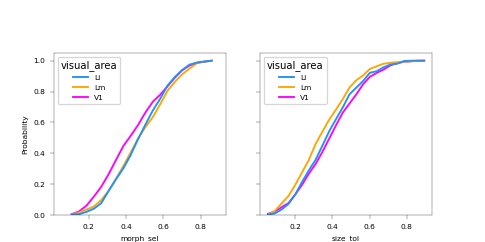

In [245]:
fig, axn=pl.subplots(1,2, figsize=(6,3), sharex=True, sharey=True)
sns.histplot(x='morph_sel', hue='visual_area', data=DF, ax=axn[0],
            palette=area_colors, stat='probability', fill=False,
            cumulative=True, common_norm=False, element='poly')
sns.histplot(x='size_tol', hue='visual_area', data=DF, ax=axn[1],
            palette=area_colors, stat='probability',fill=False,
            cumulative=True, common_norm=False, element='poly')
pl.subplots_adjust(left=0.1, bottom=0.2, top=0.8, right=0.8)

In [190]:
va ='V1'
dk = '20191006_JC110_fov1'
df_ = DF[(DF.datakey==dk) & (DF.visual_area==va)].copy()
df_[df_.cell==4][['cell', 'best_morphlevel', 'best_size']]

,cell,best_morphlevel,best_size
2127,4,92.0,30.0


In [192]:
df_[df_.cell==6][['cell', 'best_morphlevel', 'best_size']]

,cell,best_morphlevel,best_size
2129,6,106.0,30.0


In [210]:
diffdf.head()

,cell_1,cell_2,best_morphlevel,neuron_pair,best_size,cortical_distance,visual_area,datakey
0,76,80,14.0,76_80,0.0,50.195743,Li,20190422_JC076_fov1
1,76,81,66.0,76_81,10.0,73.768600,Li,20190422_JC076_fov1
2,76,119,106.0,76_119,30.0,82.268232,Li,20190422_JC076_fov1
3,76,135,106.0,76_135,30.0,189.151666,Li,20190422_JC076_fov1
4,76,136,92.0,76_136,0.0,163.134469,Li,20190422_JC076_fov1


In [215]:
# ------------------------------
cmap='viridis'
custom_bins=False
# ------------------------------
n_iterations=500
n_samples=None
# ------------------------------
# Get bins
to_quartile='cortical_distance'
n_bins=6
use_quartile=False
bins, bin_labels, bin_colors = cr.get_bins(n_bins=n_bins, custom_bins=custom_bins, 
                                            cmap=cmap)
# Bin ---------------------------------------------------
bcorrs, bins_ = cr.bin_column_values(diffdf, to_quartile=to_quartile, 
                     use_quartile=use_quartile, return_bins=True,
                     n_bins=n_bins, bins=bins, labels=bin_labels)
bcorrs = bcorrs.dropna()
# Add bin value to df
bin_values = bcorrs.groupby(['binned_%s' % to_quartile])[to_quartile].median()
bin_lut = dict((k, v) for k, v in zip(bin_labels, bin_values))
bcorrs['bin_value'] = [bin_lut[b] for b in bcorrs['binned_%s' % to_quartile]]


<IPython.core.display.Javascript object>


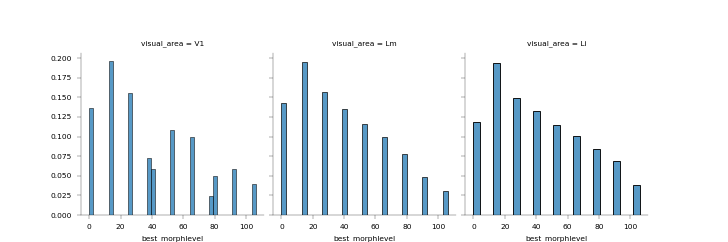

In [231]:
fg = sns.FacetGrid(col='visual_area', col_order=visual_areas, height=3, data=diffdf)
fg.map(sns.histplot, 'best_morphlevel', stat='probability', common_norm=False)
pl.subplots_adjust(left=0.1, bottom=0.2, top=0.8, right=0.8)

<IPython.core.display.Javascript object>


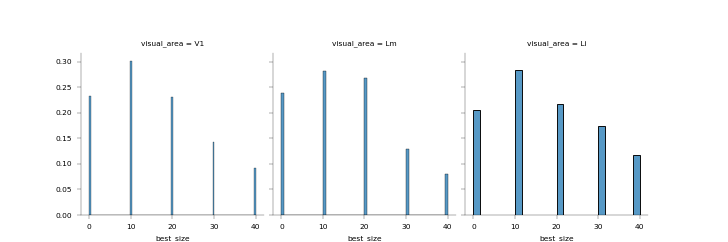

In [229]:
fg = sns.FacetGrid(col='visual_area', col_order=visual_areas, height=3, data=diffdf)
fg.map(sns.histplot, 'best_size', stat='probability', common_norm=False)
pl.subplots_adjust(left=0.1, bottom=0.2, top=0.8, right=0.8)

<IPython.core.display.Javascript object>


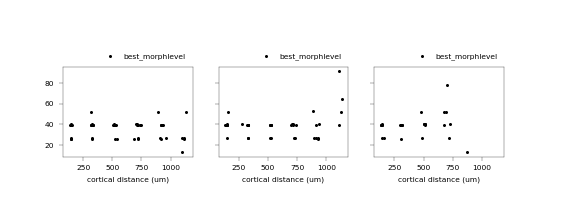

    val out of bounds
BINNED, no fit: Li
    val out of bounds
BINNED, no fit: Lm
    val out of bounds
BINNED, no fit: V1


In [216]:
n_iter=int(np.random.rand(1)[0]*500)
min_npairs = 3
x_var = 'binned_%s' % to_quartile
metric = 'best_morphlevel'
fit_sites = True
xlabel='cortical distance (um)' if to_quartile=='cortical_distance' \
            else 'RF distance (deg)'
cnt_grouper = [x_var] 
if fit_sites:
    cnt_grouper.append('datakey')
    
fig, axn = pl.subplots(1,3, figsize=(7,2.5), sharex=True, sharey=True)
for va, cc0 in bcorrs.groupby('visual_area'):
    ax=axn[visual_areas.index(va)]
    cnts = cc0.groupby(cnt_grouper)['neuron_pair'].count()  
    # How many resample per group
    nsamples_per = dict((k, v) for k, v \
                        in zip(cnts[cnts>min_npairs].index.tolist(),
                               cnts[cnts>min_npairs].values))
    # Sample
    cc_ = pd.concat([cg.sample(nsamples_per[c], random_state=n_iter, replace=True) \
                         for c, cg in cc0.groupby(cnt_grouper) \
                         if c in nsamples_per.keys()])
    # fov mean for visualizing
    fov_cc = cc_.groupby(cnt_grouper).median().reset_index().dropna()
    # plot
    ax.scatter(x=to_quartile, y=metric, data=fov_cc, 
                s=2, color='k')
    res_, xvals, yvals = cr.fit_decay_on_binned(fov_cc, use_binned=False,
                                            normalize_x=True, func='halflife',
                                            estimator='median',
                                            metric=metric,
                                            to_quartile=to_quartile,
                                            return_inputs=True)
    if all(res_.isnull()):
        print("BINNED, no fit: %s" % va)
        label='no fit'
    else:
        fit_y = cr.func_halflife(xvals, res_.init, res_.tau, res_.constant)
        label = '%s (T=%.2f)\ninit: %.1f, c=%.2f\nR2=%.2f' \
                        % (va, res_.tau, res_.init, res_.constant, res_.R2)
        ax.plot(xvals, fit_y, color='r', label=label)
    #ax.set_ylim([-0.2, 0.6])
    #ax.set_title(label, loc='left')
    ax.set_xlabel(xlabel)
    ax.legend(bbox_to_anchor=(1,1), loc='lower right', frameon=False, ncol=2)
       #ax.set_title(va)
pl.subplots_adjust(bottom=0.3, left=0.1, right=0.8, top=0.7)

In [100]:
min_ncells_plots = 50
curr_ds = cnts[ (cnts.n_cells>=min_ncells)]
curr_ds

,visual_area,datakey,n_cells,site_num
0,Li,20190315_JC070_fov1,22,0.0
2,Li,20190322_JC073_fov1,38,2.0
3,Li,20190422_JC076_fov1,29,3.0
4,Li,20190602_JC091_fov1,87,4.0
5,Li,20190609_JC099_fov1,57,5.0
6,Li,20190614_JC091_fov1,78,6.0
8,Li,20191018_JC113_fov1,47,8.0
9,Li,20191105_JC117_fov1,67,9.0
10,Li,20191111_JC120_fov1,30,10.0
11,Lm,20190306_JC061_fov3,30,0.0


In [101]:
curr_ds['visual_area'].value_counts().max()

10

<IPython.core.display.Javascript object>


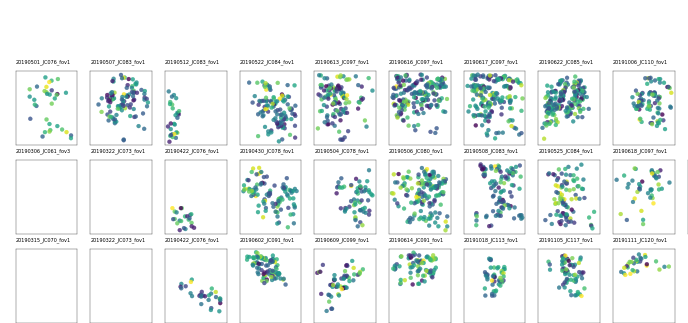

In [103]:
metric = 'morph_sel'
cmap='viridis'
max_nfovs = curr_ds['visual_area'].value_counts().max()
fig, axn = pl.subplots(3, max_nfovs, sharex=True, sharey=True, figsize=(8.5,4))

for va, curr_ in curr_ds.groupby('visual_area'):
    vi = visual_areas.index(va)
    for ai, (va, dk, nc, _) in enumerate(curr_.values):
        ax=axn[vi, ai]
        ax.set_title(dk, fontsize=4, loc='left')
        df_ = DF[(DF.visual_area==va) & (DF.datakey==dk)]

        sns.scatterplot(x='ml_pos', y='ap_pos', data=df_, ax=ax,
                        hue=metric, palette=cmap, s=10, 
                        edgecolor=None, alpha=0.8, legend=False)
        ax.set_aspect('equal')
        #ax.legend_.remove()
        ax.tick_params(which='both', axis='both', size=0)
        ax.set_xticks([])
        ax.set_yticks([])
    for ax in axn[vi, ai+1:].flat:
        ax.axis('off')
        
pl.subplots_adjust(left=0.02, right=0.98, bottom=0.1, top=0.8)

<IPython.core.display.Javascript object>


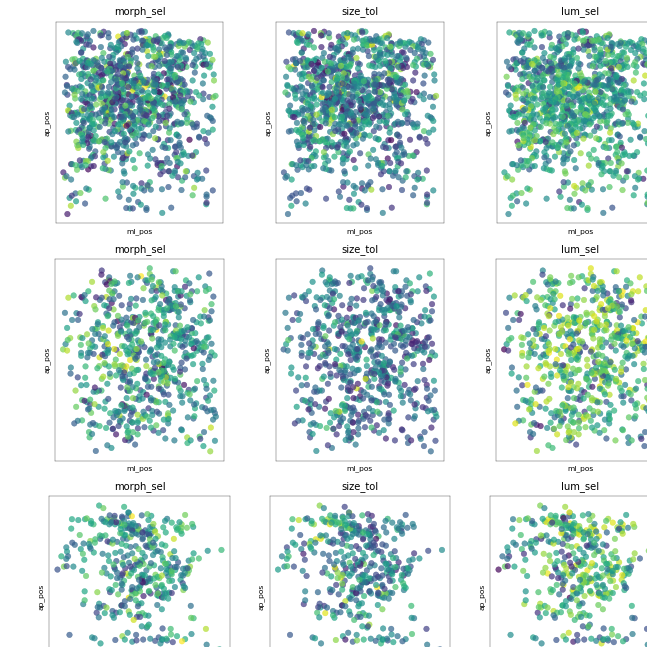

In [636]:
va = 'Lm'
dk = '20190617_JC097_fov1'

# df_ = df0[(df0.visual_area==va) & (df0.datakey==dk)]
df_ = df0[(df0.visual_area==va)]

metric_list = ['morph_sel', 'size_tol', 'lum_sel']
fig, axn = pl.subplots(3,len(metric_list), figsize=(8,8))

for va, df_ in df0.groupby('visual_area'):
    vi = visual_areas.index(va)
    for ai, metric in enumerate(metric_list):
        ax=axn[vi, ai]
        sns.scatterplot(x='ml_pos', y='ap_pos', data=df_, ax=ax,
                        hue=metric, palette=cmap, s=20, 
                        edgecolor=None, alpha=0.7, legend=False,
                        vmin=0, vmax=1)
        ax.set_aspect('equal')
        #ax.legend_.remove()
        ax.tick_params(which='both', axis='both', size=0)
        ax.set_title(metric)
        ax.set_xticks([])
        ax.set_yticks([])
pl.subplots_adjust(left=0.1, right=0.8, bottom=0.3, top=0.8, wspace=0.2, hspace=0.4)
pl.tight_layout()